#### Проведем A/B тест, используя метод линеаризации. 
###### Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
##### Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
##### После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [1]:
# Подключаемся в БД.
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231220',
'user':'student',
'password':'dpo_python_2020'
}

In [2]:
# Загружаем библиотеки и модули.
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

###### Сравниеваем группы 0 и 3.

In [3]:
# Выгружаем данные из БД.
q = '''
select  exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2023-11-18' and toDate(time) <= '2023-11-24' and  exp_group in (0,3)
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(q, connection=connection)

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000
...,...,...,...,...,...
19917,3,13781,10,27,0.370370
19918,3,130651,18,98,0.183673
19919,0,3681,7,55,0.127273
19920,3,122008,5,41,0.121951


In [5]:
# Считатем оющий ctr  в котнрольной группе.
control_ctr = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum() 

In [10]:
# Создаем колонку с линеаризированной метрикой.
df['linearized_likes'] = df.likes - control_ctr * df.views

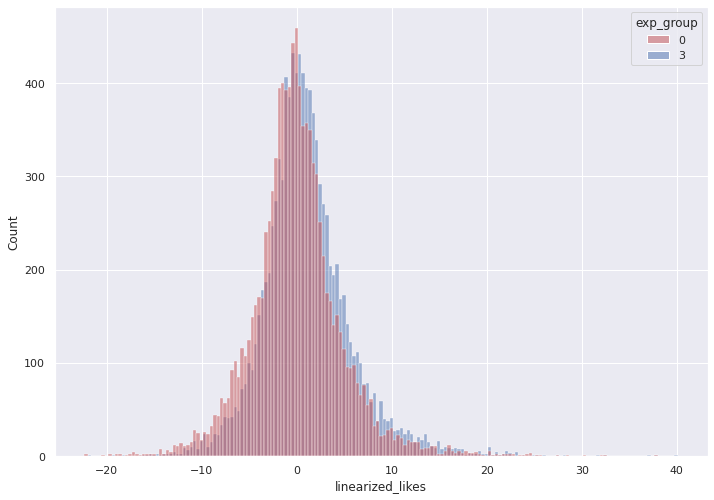

In [12]:
# Сделаем визуализацию.
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [14]:
# Проведем т-тест на обычных ctr.
stats.ttest_ind(df[df.exp_group == 0].ctr, df[df.exp_group == 3].ctr, equal_var = False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

In [15]:
# Теперь проведем т-тест на линеаризованнык кликах.
stats.ttest_ind(df[df.exp_group == 0].linearized_likes, df[df.exp_group == 3].linearized_likes, equal_var = False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

###### Линеаризированная метрика может заметить меньше изменение. Т.е. тест стал более чувствительным. Есть больше оснований отклонить нулевую гипотезу о равенстве распределений в контрольной и тестовой группах.

###### Сравниеваем группы 1 и 2.

In [16]:
# Выгружаем данные из БД.
q = '''
select  exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
where toDate(time) >= '2023-11-18' and toDate(time) <= '2023-11-24' and  exp_group in (1,2)
GROUP BY exp_group, user_id
'''
df_2 = ph.read_clickhouse(q, connection=connection)

In [17]:
df_2

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [19]:
# Считатем оющий ctr  в котнрольной группе.
control_ctr_2 = df_2[df_2.exp_group == 1].likes.sum() / df_2[df_2.exp_group == 1].views.sum() 

In [21]:
# Создаем колонку с линеаризированной метрикой.
df_2['linearized_likes'] = df_2.likes - control_ctr_2 * df_2.views

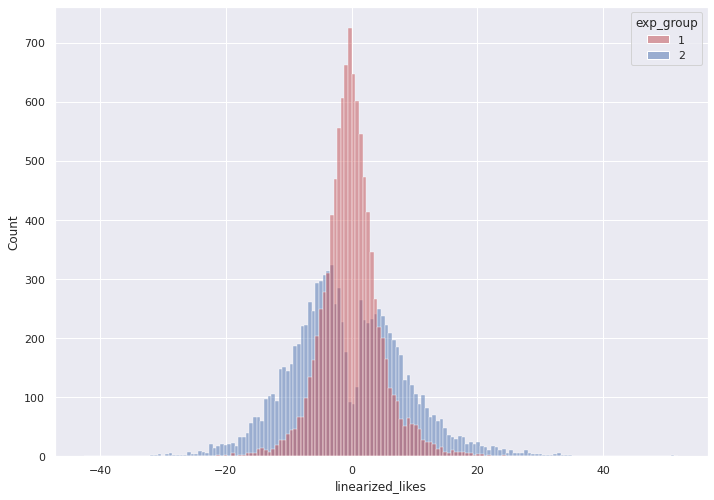

In [22]:
# Сделаем визуализацию.
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
# Проведем т-тест на обычных ctr.
stats.ttest_ind(df_2[df_2.exp_group == 1].ctr, df_2[df_2.exp_group == 2].ctr, equal_var = False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [24]:
# Теперь проведем т-тест на линеаризованнык кликах.
stats.ttest_ind(df_2[df_2.exp_group == 1].linearized_likes, df_2[df_2.exp_group == 2].linearized_likes, equal_var = False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.980506403866817e-09)

###### Сравнение обычных ctr не дает оснований отклонить нулевую гипотезу. Однако линеаризированная метрика показывает основания ее отклонить.